# Using Machine Learning to Predict NBA Games Winners

This jupyter notebook is an auxiliar material to my capstone project report in the Udacity's Machine Learning Engineer Nanodegree. The PDF file can be found in my GitHub repository:

* https://github.com/vilacham/capstone_report

---
## Importing data

As a first step, I will import the datasets and create a copy of both of them to work on:

In [1]:
# Import pandas
import pandas as pd

# Import dataset and create a copy of it
try:
    original_data = pd.read_excel('capstone_database.xlsx')
    data = original_data
    print('Dataset was successfully imported and has {} samples with {} features each.'.format(*data.shape))
except:
    print('Dataset could not be loaded. Is it missing?')

# Import dataset from 2016-2017 regular season and create a copy of it
try:
    original_data_2016_2017 = pd.read_excel('capstone_database_2016_2017.xlsx')
    data_2016_2017 = original_data_2016_2017
    print('2016-2017 dataset was successfully imported and has {} samples with {} features each.'.format(*data_2016_2017.shape))
except:
    print('2016-2017 dataset could not be loaded. Is it missing?')

Dataset was successfully imported and has 36154 samples with 96 features each.
2016-2017 dataset was successfully imported and has 2460 samples with 96 features each.


---
## Importing functions and modules
In order to make the reading of this jupyter notebook easier, I opted for writing functions and modules with more extense line codes in separated Python files: `functions.py`, `best_streak_classifier` and `majority_vote`.

The first file, `functions.py`, can be found in https://github.com/vilacham/capstone_report/blob/master/functions.py and contains the following functions:
* `preprocess`, which I will use to preprocess data (rename its columns, drop NaNs, deal with categorical data, create label column, drop unnecessary columns and convert all features to numerical data);
* `get_frequent_outliers`, which I will use to identify and drop samples that are outliers for more than one feature;
* `standardize`, which I will use to normalize features in my dataset;
* `divide_data`, which I will use to divide my dataset in three (last game data, last two games data and last five games data);
* `get_n_principal_components`, which I will use to find the *n* principal components to reduce my dataset (I aim to use those principal components that explain at least 60% of the variance);
* `plot_pca_graph`, which I will use to ploat a graph with the explained variance ratios of the principal components and the cumulative sum of these;
* `reduce`, which will reduce my dataset;
* `create_classifiers`, which will create a list containing some of the classifiers (with default parameters) that I will use in the project;
* `optimize_classifiers`, which will optimize some of the parameters of the classifiers using Grid Search technique.

The second file, `best_streak_classifier.py`, can be found in https://github.com/vilacham/capstone_report/blob/master/best_streak_classifier.py and is a class that contains code to predict a winner based only on the streak features of the home team and the visitor team: the team with the highest streak wins is predicted as the winner, and in the case of tie, the home team is predicted as the winner.

The third file, `majority_vote.py`, can be found in https://github.com/vilacham/capstone_report/blob/master/majority_vote.py and is a class that contains code to predict a winner based on the majority vote of the following classifiers:
* Logistic Regression;
* Decision Tree;
* K Nearest Neighbors;
* Gaussian NB; and
* Multi-Layer Perceptron;

In [2]:
import functions as f
from majority_vote import MajorityVoteClassifier
from best_streak_classifier import BestStreakClassifier

---
## Data preprocessing

Now that I have a copy of the dataset, my next steps are: 
* rename its columns;
* remove NaNs;
* deal with categorical data;
* create the label column; and
* drop unnecessary columns.

In [3]:
data = f.preprocess(data)
data_2016_2017 = f.preprocess(data_2016_2017)

Below, I will separate the labeled column from the features in the 2016-2017 regular season dataset:

In [4]:
X_2016_2017, y_2016_2017 = data_2016_2017.iloc[:, :-1], data_2016_2017.iloc[:, -1]

Because the 2016-2017 regular season dataset does not contain games that occurred in the months 5 and 6, I will create the columns 'MTH_5' and 'MTH_6' and insert them in the dataset. This is crucial for the dimensonality reduction that will occur ahead. The code cell below creates the new features columns and transform the database:

In [5]:
# Create columns
X_2016_2017['MTH_5'] = 0
X_2016_2017['MTH_6'] = 0

# Put them in the dataset
cols = X_2016_2017.columns.tolist()
cols = cols[:-4] + cols[-2:] + cols[-4:-2]
X_2016_2017 = X_2016_2017[cols]

Below, I will remove all the outliers in the dataset:

In [6]:
outliers = f.get_frequent_outliers(data)
good_data = data.drop(data.index[outliers]).reset_index(drop=True)
print('{} outliers for more than one feature.'.format(len(outliers)))
print('Original data had {} samples.'.format(data.shape[0]))
print('Good data has {} samples.'.format(good_data.shape[0]))
print('2016-2017 data has {} samples'.format(data_2016_2017.shape[0]))

3214 outliers for more than one feature.
Original data had 16926 samples.
Good data has 13712 samples.
2016-2017 data has 1151 samples


Below I will check the first lines of `good_data`:

In [7]:
good_data.head()

,A STK,H STK,A PTS LG,A FGM LG,A FGA LG,A 3PM LG,A 3PA LG,A FTM LG,A FTA LG,A OREB LG,...,DAY_Wednesday,MTH_1,MTH_2,MTH_3,MTH_4,MTH_5,MTH_6,MTH_11,MTH_12,WINNER
0,-5,-3,88.0,35.0,80.0,5.0,15.0,13.0,16.0,13.0,...,0,0,0,0,0,0,0,1,0,1
1,-1,2,84.0,34.0,76.0,1.0,12.0,15.0,19.0,11.0,...,0,0,0,0,0,0,0,1,0,1
2,1,1,94.0,40.0,80.0,1.0,7.0,13.0,19.0,15.0,...,0,0,0,0,0,0,0,1,0,1
3,-2,1,95.0,38.0,96.0,4.0,23.0,17.0,18.0,13.0,...,0,0,0,0,0,0,0,1,0,1
4,1,-4,106.0,43.0,80.0,3.0,8.0,17.0,25.0,8.0,...,0,0,0,0,0,0,0,1,0,1


In the next code cell, I will split the dataset into training and testing sets:

In [8]:
# import train_test_split
from sklearn.model_selection import train_test_split

# Split dataset
X, y = good_data.iloc[:, :-1], good_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In the following code cell, I will standardize all the continuous variables in the training set:

In [9]:
X_train, X_test, X_2016_2017 = f.standardize(X_train, X_test, X_2016_2017)

Below, I will split the dataset into three:
* one with last game stats;
* one with the average of the last two games stats; and
* one with the average of the last five games stats.

In [10]:
train_lg, train_l2g, train_l5g = f.divide_data(X_train)
test_lg, test_l2g, test_l5g = f.divide_data(X_test)
X_2016_2017_lg, X_2016_2017_l2g, X_2016_2017_l5g = f.divide_data(X_2016_2017)

---
## Data exploration
I have explored the dataset in another notebook, which is located in the same directory as this one and is called "exploration".

---
## Last game

In [11]:
n_comp_lg = f.get_n_principal_components(train_lg, 0.6)
print('Number of components: {}'.format(n_comp_lg))

Number of components: 6


The code cell below will reduce the following datasets:
* train_lg;
* test_lg; and
* X_2016_2017_lg.

In [12]:
train_lg_reduced, test_lg_reduced, X_2016_2017_lg_reduced = f.reduce(train_lg, test_lg, X_2016_2017_lg, n_comp_lg)

---
## Last two games

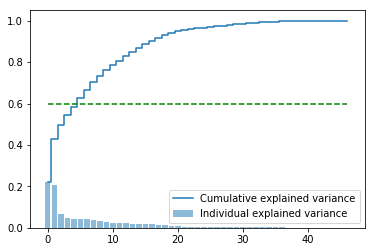

Number of components: 6


In [13]:
n_comp_l2g = f.get_n_principal_components(train_l2g, 0.6)
print('Number of components: {}'.format(n_comp_l2g))

The code cell below will reduce the following datasets:
* train_l2g;
* test_l2g; and
* X_2016_2017_l2g.

In [14]:
train_l2g_reduced, test_l2g_reduced, X_2016_2017_l2g_reduced = f.reduce(train_l2g, test_l2g, X_2016_2017_l2g, n_comp_l2g)

---
## Last five games

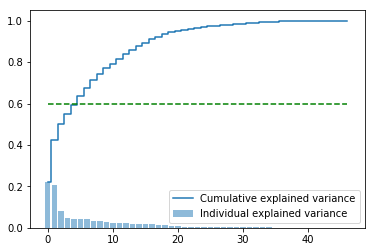

Number of components: 6


In [15]:
n_comp_l5g = f.get_n_principal_components(train_l5g, 0.6)
print('Number of components: {}'.format(n_comp_l5g))

The code cell below will reduce the following datasets:
* train_l5g;
* test_l5g; and
* X_2016_2017_l5g.

In [16]:
train_l5g_reduced, test_l5g_reduced, X_2016_2017_l5g_reduced = f.reduce(train_l5g, test_l5g, X_2016_2017_l5g, n_comp_l5g)

---
# Best Streak Classifier
In the code cells below, I will check the accuracy and the confusion matrix of the best streak classifier:

In [17]:
bsc_2016_2017 = BestStreakClassifier(data_2016_2017['H STK'].values, data_2016_2017['A STK'].values)
print('Best Streak Classifier score in 2016-2017 dataset: {:.3f}'.format(bsc_2016_2017.score(data_2016_2017.iloc[:, -1])))

Best Streak Classifier score in 2016-2017 dataset: 0.552


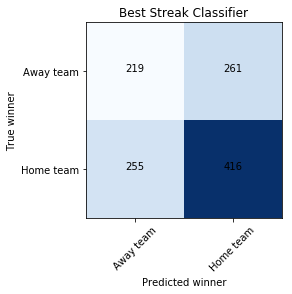

In [18]:
from sklearn.metrics import confusion_matrix

bsc_predictions = bsc_2016_2017.predict()
cm_bsc = confusion_matrix(y_2016_2017, bsc_predictions)
f.plot_confusion_matrix(cm_bsc, False, 'Best Streak Classifier')

---
## Logistic Regression Classifier
In the code cells below, I will train and test a logistic regression classifier (untouched and untuned) to serve as a benchmark model for each of the data sets.

In [19]:
# Import
from sklearn.linear_model import LogisticRegression

# Create one classifier for each of the datasets
lr_lg = LogisticRegression(random_state=42)
lr_l2g = LogisticRegression(random_state=42)
lr_l5g = LogisticRegression(random_state=42)

Below, I will train lr_lg in the last game dataset and check its accuracy and confusion matrix in the 2016-2017 regular season dataset:

In [20]:
lr_lg.fit(train_lg_reduced, y_train)

lr_lg_score = lr_lg.score(X_2016_2017_lg_reduced, y_2016_2017)

print('Logistic regression score in the 2016-2017 dataset (trained with the last game dataset): {:.3f}'.format(lr_lg_score))

Logistic regression score in the 2016-2017 dataset (trained with the last game dataset): 0.591


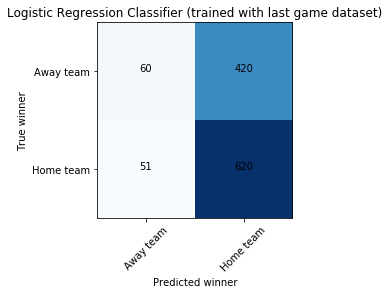

In [39]:
from sklearn.metrics import confusion_matrix

lr_lg_predictions = lr_lg.predict(X_2016_2017_lg_reduced)
cm_lr_lg = confusion_matrix(y_2016_2017, lr_lg_predictions)

f.plot_confusion_matrix(cm_lr_lg, False, 'Logistic Regression Classifier (trained with last game dataset)')

Below, I will train lr_l2g in the last two games dataset and check its accuracy and confusion matrix in the 2016-2017 regular season dataset:

In [22]:
lr_l2g.fit(train_l2g_reduced, y_train)

lr_l2g_score = lr_l2g.score(X_2016_2017_l2g_reduced, y_2016_2017)

print('Logistic regression score in the 2016-2017 dataset (trained with the last two games dataset): {:.3f}'.format(lr_l2g_score))

Logistic regression score in the 2016-2017 dataset (trained with the last two games dataset): 0.590


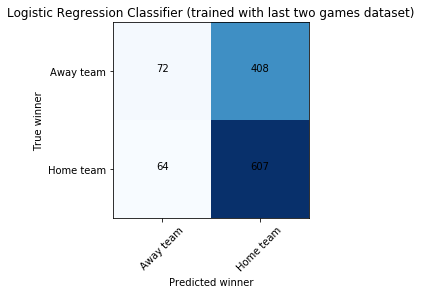

In [23]:
lr_l2g_predictions = lr_l2g.predict(X_2016_2017_l2g_reduced)
cm_lr_l2g = confusion_matrix(y_2016_2017, lr_l2g_predictions)

f.plot_confusion_matrix(cm_lr_l2g, False, 'Logistic Regression Classifier (trained with last two games dataset)')

Below, I will train lr_l5g in the last five games dataset and check its accuracy and confusion matrix in the 2016-2017 regular season dataset:

In [24]:
lr_l5g.fit(train_l5g_reduced, y_train)

lr_l5g_score = lr_l5g.score(X_2016_2017_l5g_reduced, y_2016_2017)

print('Logistic regression score in the 2016-2017 dataset (trained with the last five games dataset): {:.3f}'.format(lr_l5g_score))

Logistic regression score in the 2016-2017 dataset (trained with the last five games dataset): 0.594


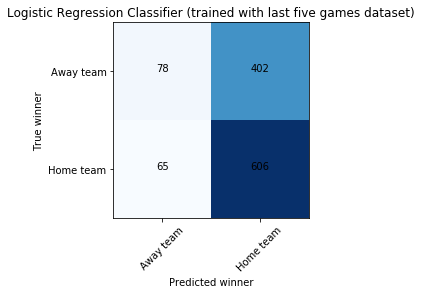

In [25]:
lr_l5g_predictions = lr_l5g.predict(X_2016_2017_l5g_reduced)
cm_lr_l5g = confusion_matrix(y_2016_2017, lr_l5g_predictions)

f.plot_confusion_matrix(cm_lr_l5g, False, 'Logistic Regression Classifier (trained with last five games dataset)')

---
## Create and optimize classifiers
In the code cells below, I will create and optimize the list of classifiers used in the majority vote classifier.

In [26]:
classifiers_list = f.create_classifiers()
for i in range(len(classifiers_list)):
    print(classifiers_list[i][1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
GaussianNB(priors=None)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
     

---
# Majority vote classifier
In the code cells below, I will create one majority vote classifier for each dataset and check their accuracy and confusion matrix over the 2016-2017 regular season dataset.

## Last game

In [27]:
mvc_lg = MajorityVoteClassifier(classifiers_list)
mvc_lg.fit(train_lg_reduced, y_train)
mvc_lg_score = mvc_lg.score(X_2016_2017_lg_reduced, y_2016_2017)
print('Majority vote classifier score in the 2016-2017 regular season dataset: {:.5f}'.format(mvc_lg_score))

Majority vote classifier score in the 2016-2017 regular season dataset: 0.59427


In the code cells below, I will optimize the classifiers and calculate its new accuracy and confusion matrix:

In [28]:
optimized_classifiers_lg = f.optimize_classifiers(mvc_lg.classifiers, train_lg_reduced, y_train)

-----------------------------------------------------------------------------------------------------------------------------
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best parameters: {'C': 0.0001, 'class_weight': None, 'solver': 'saga'}
Best score: 0.612
-----------------------------------------------------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
Best parameters: {'class

In [29]:
mvc_lg.classifiers = optimized_classifiers_lg
mvc_lg_score_optimized = mvc_lg.score(X_2016_2017_lg_reduced, y_2016_2017)
print('MVC score in the 2016-2017 regular season dataset after optimizing classifiers: {:.5f}'.format(mvc_lg_score_optimized))

MVC score in the 2016-2017 regular season dataset after optimizing classifiers: 0.59513


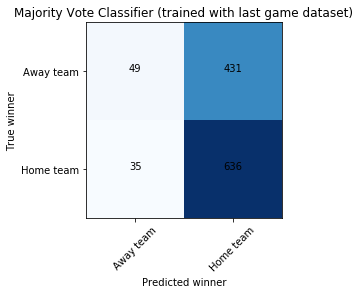

In [30]:
# I will plot the non-optimized majority vote classifier because it has a higher accuracy when compared with the optimized one 
mvc_lg_predictions = mvc_lg.predict(X_2016_2017_lg_reduced)
cm_mvc_lg = confusion_matrix(y_2016_2017, mvc_lg_predictions)

f.plot_confusion_matrix(cm_mvc_lg, False, 'Majority Vote Classifier (trained with last game dataset)')

## Last two games

In [31]:
mvc_l2g = MajorityVoteClassifier(classifiers_list)
mvc_l2g.fit(train_l2g_reduced, y_train)
mvc_l2g_score = mvc_l2g.score(X_2016_2017_l2g_reduced, y_2016_2017)
print('Majority vote classifier score in the 2016-2017 regular season dataset: {:.5f}'.format(mvc_l2g_score))

Majority vote classifier score in the 2016-2017 regular season dataset: 0.58732


In the code cells below, I will optimize the classifiers and calculate its new accuracy and confusion matrix:

In [32]:
optimized_classifiers_l2g = f.optimize_classifiers(mvc_l2g.classifiers, train_l2g_reduced, y_train)

C:\Users\mathe\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\mathe\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


-----------------------------------------------------------------------------------------------------------------------------
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best parameters: {'C': 0.0001, 'class_weight': None, 'solver': 'saga'}
Best score: 0.613
-----------------------------------------------------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
Best parameters: {'class

In [33]:
mvc_l2g.classifiers = optimized_classifiers_l2g
mvc_l2g_score_optimized = mvc_l2g.score(X_2016_2017_l2g_reduced, y_2016_2017)
print('MVC score in the 2016-2017 regular season dataset after optimizing classifiers: {:.5f}'.format(mvc_l2g_score_optimized))

MVC score in the 2016-2017 regular season dataset after optimizing classifiers: 0.58992


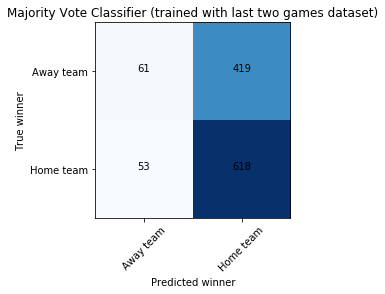

In [34]:
mvc_l2g_predictions = mvc_l2g.predict(X_2016_2017_l2g_reduced)
cm_mvc_l2g = confusion_matrix(y_2016_2017, mvc_l2g_predictions)

f.plot_confusion_matrix(cm_mvc_l2g, False, 'Majority Vote Classifier (trained with last two games dataset)')

## Last five games

In [35]:
mvc_l5g = MajorityVoteClassifier(classifiers_list)
mvc_l5g.fit(train_l5g_reduced, y_train)
mvc_l5g_score = mvc_l5g.score(X_2016_2017_l5g_reduced, y_2016_2017)
print('Majority vote classifier score in the 2016-2017 regular season dataset: {:.5f}'.format(mvc_l5g_score))

Majority vote classifier score in the 2016-2017 regular season dataset: 0.58818


In the code cells below, I will optimize the classifiers and calculate its new accuracy and confusion matrix:

In [36]:
optimized_classifiers_l5g = f.optimize_classifiers(mvc_l5g.classifiers, train_l5g_reduced, y_train)

-----------------------------------------------------------------------------------------------------------------------------
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best parameters: {'C': 0.001, 'class_weight': None, 'solver': 'saga'}
Best score: 0.614
-----------------------------------------------------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
Best parameters: {'class_

In [37]:
mvc_l5g.classifiers = optimized_classifiers_l5g
mvc_l5g_score_optimized = mvc_l5g.score(X_2016_2017_l5g_reduced, y_2016_2017)
print('MVC score in the 2016-2017 regular season dataset after optimizing classifiers: {:.5f}'.format(mvc_l5g_score_optimized))

MVC score in the 2016-2017 regular season dataset after optimizing classifiers: 0.58992


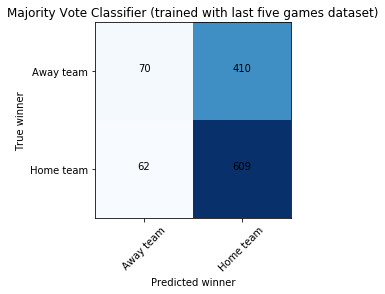

In [38]:
mvc_l5g_predictions = mvc_l5g.predict(X_2016_2017_l5g_reduced)
cm_mvc_l5g = confusion_matrix(y_2016_2017, mvc_l5g_predictions)

f.plot_confusion_matrix(cm_mvc_l5g, False, 'Majority Vote Classifier (trained with last five games dataset)')